# Analysis of US Past, Present, and Future Riskless rates as represented by Fed Funds Rates and 10-Year Treasury Yields
The Federal Funds Rate and 10-year Treasury Securities yield are used as short-term and long-term riskfree rates respectively. The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. When a depository institution has surplus balances in its reserve account, it lends to other banks in need of larger balances.10-Year Treasury Yield indicates the rate at which U.S. Department of the Treasury can presently borrow from the public. 

There's a relationship between riskfree rates (e.g. 10-year Treasury rates) and CPI + real GDP growth rates. CPI + GDP growth rates is known as _the intrinsic riskfree rate_. In theory the 10-year Treasury rate should be similar to the intrinsic riskfree rate.

In this notebook I first construct the current riskfree curve (based on the most recent US Treasury Yields of different maturities) as well as current real rates curve based on the most recent Treasury inflation protected security (TIPS) yields of different maturities. This allows to infer forward 10-year Treasury Yields later in this notebook.

Unlike the [US CPI, Fed Funds Effective Rate, Market Yield on US Treasury Securities at 10-Year... notebook](https://github.com/ilchen/US_Economic_Data_Analysis/blob/main/CPI_and_Fed_Funds_Rates.ipynb) where I look at monthly changes in riskfree rates, expected inflation, and riskless curves, in this notebook I then concentrate on inferring future Fed Funds rates and 10-year Treasury Yields from the futures contracts traded on CME and depict the past, present, and future riskfree rates in one graph. For 10-year Treasury Yields I also use forward yields inferred from the earlier constructed  US Treasury Yield curve.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay, MonthBegin, MonthEnd
from dateutil.relativedelta import relativedelta
from datetime import date
import yfinance as yfin

from pricing import curves, futures_rates

In [3]:
report_end = date.today()
report_start = report_end - relativedelta(months=+28)

In [4]:
dff_tr10 = web.get_data_fred(['DFF', 'DGS10'], start=report_start, end=report_end) / 100.

## Current US Treasury and US Real Rates Curves
In this part of the notebook I construct the US Treasury Yield curve based on the most recent market yields on U.S. Treasury Securities at different maturities published by [FRED](https://fred.stlouisfed.org). I also use this curve in the second half of the notebook to infer forward treasury yields. I use the Fed Funds effective rate as proxy for instantaneous riskless rate.


I also constuct the most recent US Real Treasury yield curve. Real rates are yields on Treasury inflation protected security (TIPS). The reason they are called _real_ is because an investor in a TIPS security is automatically compensated for CPI inflation. That is the current yield on a TIPS security is the rate of return the investor is guaranteed to get when inflation is accounted for.

Unfortunately the Fed only publishes TIPS yields for a limited set of constant maturities: 5 years, 7 years, 10 years, 20 years, and 30 years. In the following part of the notebook I constract the missing maturities for 1 and 2 years by subtracting the most recent expected inflation for 1 and 2 years from treasury yields of the same maturities. For the instant real rate I subtract the most recent CPI from the most recent Fed Funds rate.

I use the following dataseries from [FRED](https://fred.stlouisfed.org) to accomplish the task for  Treasury Yield Curve construction:
* DFF &mdash; Federal Funds Effective Rate (daily frequency)
* DGS1MO &mdash;  Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3MO &mdash;  Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS6MO &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS1 &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* ...
* DGS20 &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS30 &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

and additionally these series to construct the TIPS Real Yield curve:
* CPIAUCSL &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency)
* EXPINF1YR &mdash; 1-Year Expected Inflation (monthly frequency)
* EXPINF2YR &mdash; 2-Year Expected Inflation (monthly frequency)
* DFII5 &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed (daily frequency)
* ...
* DFII30 &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed (daily frequency)

In [5]:
today = date.today()

# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'],
    today - relativedelta(weeks=+6) - BDay(2), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Please choose an appropritate date in the past for comparison
# delta = relativedelta(weeks=+1)
delta = relativedelta(months=+1)
# past_label = '1 week prior'
past_label = '1 month prior'

# Ensuring we go back to the last business day a week ago
past_date = BDay(0).rollback(cur_date_curve - delta)

# Convert to percentage points
data /= 100.

# Some adjustments are required to bring FED Funds rate to the same day count convention and compounding frequency
# as treasury yields (actual/actual with semi-annual compounding):
# 1. https://www.federalreserve.gov/releases/h15/default.htm -> day count convention for Fed Funds Rate needs
# to be changed to actual/actual
# 2. Conversion from annual to semi-annual compounding: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions
data.DFF *= (366 if curves.YieldCurve.is_leap_year(cur_date_curve.year) else 365) / 360 # to x/actual
data.DFF = 2 * (np.sqrt(data.DFF + 1) - 1)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20),
           relativedelta(years=+30)]

# Define the riskless yield curve
curve = curves.YieldCurve(today, offsets, data[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                          compounding_freq=2)
past_curve = curves.YieldCurve(past_date, offsets,
                               data[past_date:past_date+BDay()].to_numpy()[0,:], compounding_freq=2)

In [6]:
real_rates = web.get_data_fred(['DFII5', 'DFII7', 'DFII10', 'DFII20', 'DFII30'],
                               today - relativedelta(weeks=+6) - BDay(2), today) / 100.
real_rates.dropna(inplace=True)

# Infer real rates from the most recent expected inflation and current treasury yields
expected_infl = web.get_data_fred(['EXPINF1YR', 'EXPINF2YR'], today - MonthBegin(2), today) / 100.

# We need to convert expected inflation from annual to semi-annual compounding
expected_infl = 2 * (np.sqrt(expected_infl + 1) - 1)

real_rates_1y_2y = data.iloc[-1,[4,5]].set_axis(expected_infl.iloc[-1,:].index) - expected_infl.iloc[-1,:]
real_rates.insert(0, 'DFII2', real_rates_1y_2y[1])
real_rates.insert(0, 'DFII1', real_rates_1y_2y[0])

# Infer the current real rate from the difference between most recent Fed Funds Rate and CPI
cpi = web.get_data_fred('CPIAUCSL', today - MonthBegin(14), today).pct_change(12)

# We need to convert cpi from annual to semi-annual compounding, as we did earlier for the fedfunds rate
cpi = 2 * (np.sqrt(cpi + 1) - 1)

real_rates.insert(0, 'INST', dff_tr10.iloc[-1,0]-cpi.iloc[-1,0])

# Unfortunately fewer curve points for TIPS
offsets_tips = [relativedelta(), relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+5),
                relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]
curve_real_rates = curves.YieldCurve(today, offsets_tips, real_rates[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                                     compounding_freq=2)
past_curve_real_rates = curves.YieldCurve(
    today, offsets_tips, real_rates[past_date:past_date + BDay()].to_numpy()[0, :], compounding_freq=2)

In [7]:
curve_points = curve.get_curve_points(120)
curve_points_past = past_curve.get_curve_points(120)
curve_points.rename('US Treasury Yield', inplace=True)
curve_points_past.rename(curve_points.name + f' ({past_label})', inplace=True)

curve_points_real = curve_real_rates.get_curve_points(120)
curve_points_real_past = past_curve_real_rates.get_curve_points(120)
curve_points_real.rename('US TIPS (Real) Yield', inplace=True)
curve_points_real_past.rename(curve_points_real.name + f' ({past_label})', inplace=True)

# Replacing indices for sake of better visualization
df = pd.concat([curve_points, curve_points_real, curve_points_past.set_axis(curve_points.index),
                curve_points_real_past.set_axis(curve_points_real.index)], axis=1)

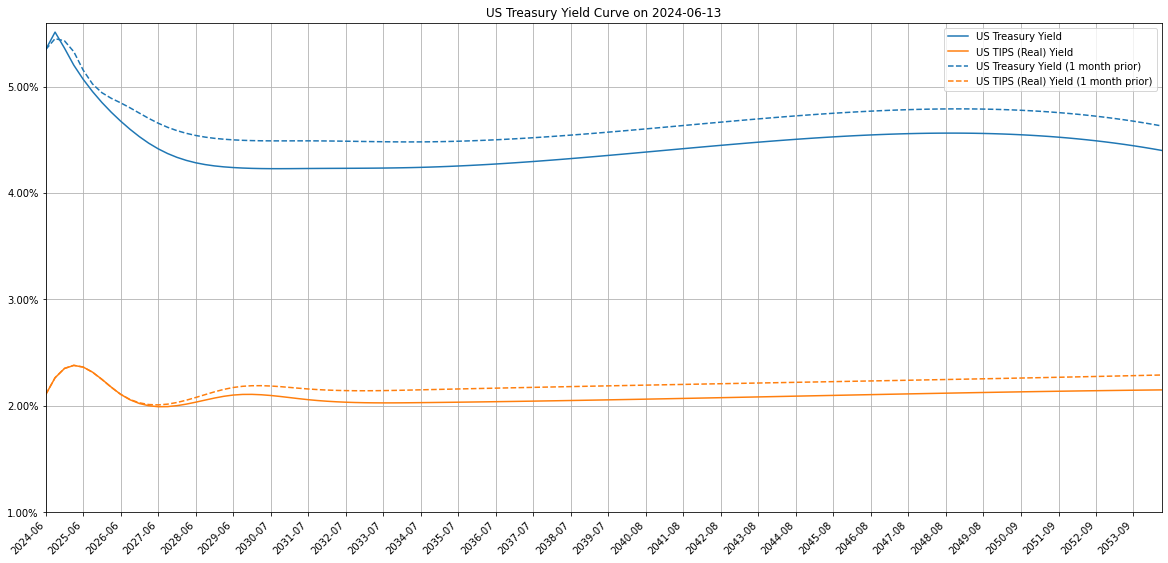

In [8]:
ax = df.iloc[:,:2].plot(figsize=(20,10), grid=True, title=f'US Treasury Yield Curve on {cur_date_curve:%Y-%m-%d}',
                        xlim=(curve_points.index[0], curve_points.index[-1]),
                        xticks=curve_points.index[::4], xlabel='', rot=45, ylim=(.01, .056))
df.iloc[:,2:].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4', '#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, curve_points.index[::4])))

In [9]:
print('The Yield Curve on {:%Y-%m-%d} changed by an average of {:+.2f}bps compared to {:s}'
      .format(data.index[-1].date(), 10000 * (df.iloc[:,0].mean() - df.iloc[:,2].mean()), past_label))
print('The TIPS (Real) Curve on {:%Y-%m-%d} changed by an average of {:+.2f}bps compared to {:s}'
      .format(data.index[-1].date(), 10000 * (df.iloc[:,1].mean() - df.iloc[:,3].mean()), past_label))

The Yield Curve on 2024-06-13 changed by an average of -22.06bps compared to 1 month prior
The TIPS (Real) Curve on 2024-06-13 changed by an average of -10.64bps compared to 1 month prior


In [10]:
till = cur_date_curve + relativedelta(years=+10)
print('For up till 10y the Yield Curve on {:%Y-%m-%d} changed by an average of {:.2f}bps compared to {:s}'
      .format(data.index[-1].date(),
              10000 * (df.loc[:till,df.columns[0]].mean() - df.loc[:till,df.columns[2]].mean()), past_label))
print('For up till 10y the TIPS (Real) Curve on {:%Y-%m-%d} changed by an average of {:.2f}bps compared {:s}'
      .format(data.index[-1].date(),
              10000 * (df.loc[:till,df.columns[1]].mean() - df.loc[:till,df.columns[3]].mean()), past_label))

For up till 10y the Yield Curve on 2024-06-13 changed by an average of -21.18bps compared to 1 month prior
For up till 10y the TIPS (Real) Curve on 2024-06-13 changed by an average of -5.91bps compared 1 month prior


In [11]:
offset_in_years = 3

In [12]:
print('Average long-term (>{:d}y) treasury yield: {:.2%}'.format(offset_in_years,
    df.loc[(data.index[-1].date()+relativedelta(years=+3)):,df.columns[0]].mean()))

Average long-term (>3y) treasury yield: 4.39%


In [13]:
print('Long-term (>{:d}y) treasury yield: {:.2%}-{:.2%}'.format(offset_in_years,
    curve_points.loc[(data.index[-1].date()+relativedelta(years=+offset_in_years)):].min(),
    curve_points.loc[(data.index[-1].date()+relativedelta(years=+offset_in_years)):].max()))

Long-term (>3y) treasury yield: 4.23%-4.56%


In [14]:
print('Average long-term (>3y) real yield: {:.2%}'.format(
    df.loc[(data.index[-1].date()+relativedelta(years=+3)):,df.columns[1]].mean()))

Average long-term (>3y) real yield: 2.08%


In [15]:
print('Long-term (>{:d}y) real yield: {:.2%}-{:.2%}'.format(offset_in_years,
    curve_points_real.loc[(data.index[-1].date()+relativedelta(years=+offset_in_years)):].min(),
    curve_points_real.loc[(data.index[-1].date()+relativedelta(years=+offset_in_years)):].max()))

Long-term (>3y) real yield: 1.99%-2.15%


## Past, Present, and Future: Fed Funds Rates and 10-year Treasury Yields
I obtain future Fed Funds Rates and 10-year Treasury Yields from the following futures contracts traded on CME:
* [30 Day Federal Funds](https://www.cmegroup.com/markets/interest-rates/stirs/30-day-federal-fund.html) futures contracts, and
* [10 Year T-Note](https://www.cmegroup.com/markets/interest-rates/us-treasury/10-year-us-treasury-note.html) futures contracts<sup>1</sup>.
I use helper classes `CMEFedFundsFuturesRates` and `CME10YearTNoteFuturesYields` from the `pricing.futures_rates` package to do the heavy lifting.

CME allows for a variety of maturities of Treasury notes to be delivered during a 10-Year Treasury Note futures contract's final settlement. In particular Treasury notes with maturities starting from 6.5 years can be delivered. Therefore future yields deduced from these contracts are but a rough approximation of future 10-year Treasury Yields. Therefore in below I use them only for reference. As the main representation of future 10-year Treasury Yields, I use forward treasury yields obtained from the Treasury Yield curve I've constructed in the first half of this notebook. I calculate forward treasury yield for each future month based on the first business day from the month's middle.

I retrieve the past and current riskfree rates from the following dataseries provided by [FRED](https://fred.stlouisfed.org):
* DFF &mdash; Federal Funds Effective Rate (daily frequency)
* DGS10 &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

[1] Unfortunately only the contracts for the next two quarters are actively traded for [this instrument](https://www.cmegroup.com/markets/interest-rates/us-treasury/10-year-us-treasury-note.quotes.html) on CME. 

In [16]:
# Resampling to monthly frequencies by taking the average for each month,
# but using the last price for the current month
ff_tr10 = pd.concat([dff_tr10.loc[:report_end - MonthEnd(2)].resample('MS').mean(),
                     dff_tr10.loc[report_end - MonthEnd(2) + BDay():].resample('MS').last()])

In [17]:
# A kludge for pandas-datareader not being able to cope with latest Yahoo-Finance changes
yfin.pdr_override()

# Inferring future Fed Funds and 10 Year Treasury Note yields for the futures contracts traded on CME
inferrer_ff_rates = futures_rates.CMEFedFundsFuturesRates(cur_date_curve)
inferrer_tnote_yields = futures_rates.CME10YearTNoteFuturesYields(cur_date_curve)
ff_rates = inferrer_ff_rates.get_rates_for_next_n_months(16)
tr10_yields = inferrer_tnote_yields.get_yields_for_next_n_quarters(3)

ff_rates_past = inferrer_ff_rates.get_rates_for_next_n_months(16, past_date)
tr10_yields_past = inferrer_tnote_yields.get_yields_for_next_n_quarters(3, past_date)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  3 of 3 completed

1 Failed download:
['ZNH25.CBT']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[                       0%%                      ]

Objective function: -0.00008 after 18 iterations
Objective function: -0.00020 after 18 iterations


[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  3 of 3 completed

1 Failed download:
['ZNH25.CBT']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Objective function: -0.00103 after 16 iterations
Objective function: -0.00077 after 18 iterations


In [18]:
# Calculating forward treasury yields from the earlier constructed Treasury Yield Curves
term = relativedelta(years=+10)

def to_forward_yield(forward_date, fn):
    forward_date = forward_date + relativedelta(weeks=+2) + BDay(0)
    return fn(forward_date, forward_date + term)[0]

from functools import partial

forward_tr10_yields = ff_rates.index.to_series().apply(
    partial(to_forward_yield, fn=curve.get_forward_yield_for_maturity_date))
forward_tr10_yields_past = ff_rates.index.to_series().apply(
    partial(to_forward_yield, fn=past_curve.get_forward_yield_for_maturity_date))

In [19]:
# Renaming the future Fed Funds and T-Note series to have the same name as those retrieved earlier
ff_rates.rename(ff_tr10.columns[0], inplace=True)
#tr10_yields.rename(ff_tr10.columns[1], inplace=True)
forward_tr10_yields.rename(ff_tr10.columns[1], inplace=True)

# Concatenating future rates and yields into a DataFrame
future_rates = pd.concat([ff_rates, forward_tr10_yields], axis=1)

In [20]:
# And now merging the past, current, and future rates/yields 
ext_ff_tr10 = pd.concat([ff_tr10, future_rates])
ext_ff_tr10.rename(
    columns={'DFF': 'Federal Funds Effective Rate',
             'DGS10': '10y Treasury Yield'},
    inplace=True)

PAST_DATE = f' ({past_label})'
FROM_FUTURES = ' (inferred from futures)'
FROM_FUTURES_PAST_DATE = f' (inferred from futures, {past_label})'

ff_rates.rename(ext_ff_tr10.columns[0] + FROM_FUTURES, inplace=True)
ff_rates_past = pd.concat([ff_rates_past, ff_tr10.DFF.iloc[-1:]]).sort_index()
ff_rates_past.rename(ext_ff_tr10.columns[0] + FROM_FUTURES_PAST_DATE, inplace=True)
forward_tr10_yields.rename('Forward 10y Treasury Yield', inplace=True)
forward_tr10_yields_past = pd.concat([forward_tr10_yields_past, ff_tr10.DGS10.iloc[-1:]]).sort_index()
forward_tr10_yields_past.rename(forward_tr10_yields.name + PAST_DATE, inplace=True)
#tr10_yields_ = pd.concat([tr10_yields, ff_tr10.DGS10.iloc[-1:]]).sort_index()
tr10_yields.rename(ext_ff_tr10.columns[1] + FROM_FUTURES, inplace=True)
tr10_yields_past.rename(ext_ff_tr10.columns[1] + FROM_FUTURES_PAST_DATE, inplace=True)

ext2_ff_tr10 = pd.concat([ff_rates, forward_tr10_yields, ff_rates_past, forward_tr10_yields_past], axis=1)

ext2_tr10 = pd.concat([tr10_yields, tr10_yields_past], axis=1)

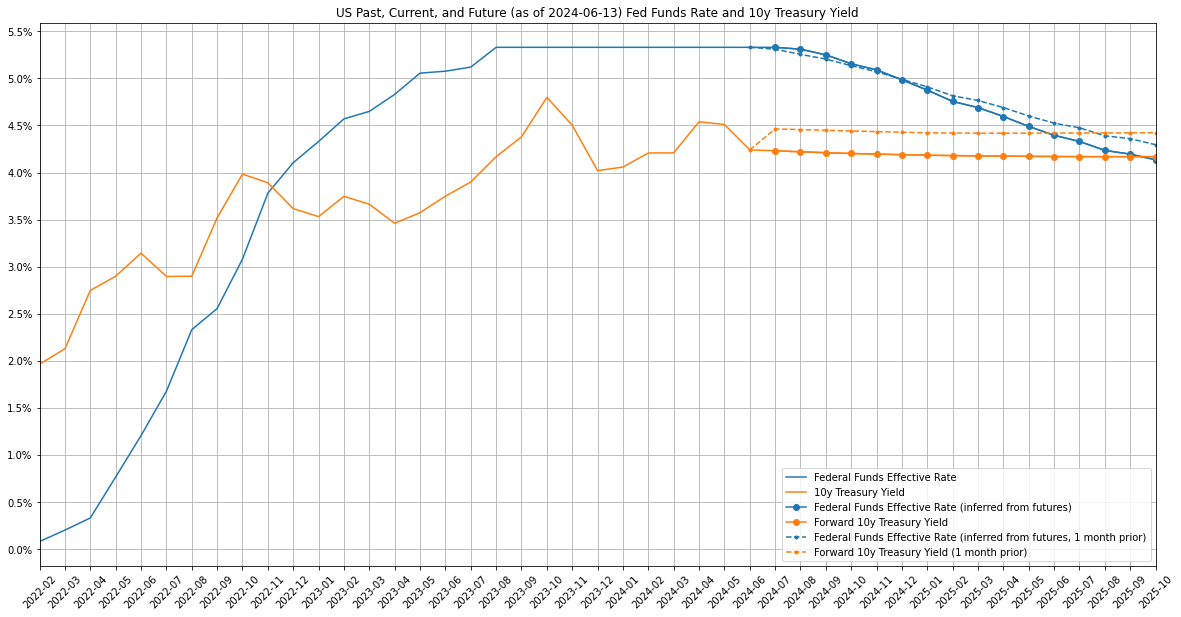

In [21]:
ax = ext_ff_tr10.plot(figsize=(20,10), grid=True,
                      title=f'US Past, Current, and Future (as of {cur_date_curve:%Y-%m-%d}) Fed Funds Rate and 10y Treasury Yield',
                      xticks=ext_ff_tr10.index, xlabel='', rot=45)
ext2_ff_tr10.iloc[:,:2].plot(ax=ax, grid=True, marker='o', xticks=ext_ff_tr10.index, xlabel='',
              rot=45, yticks=np.arange(0, .06, 0.01), color=['#1f77b4','#ff7f0e'])
ext2_ff_tr10.iloc[:,2:].plot(ax=ax, grid=True, marker='.', linestyle='--', xticks=ext_ff_tr10.index, xlabel='',
              rot=45, yticks=np.arange(0, .06, 0.005), color=['#1f77b4','#ff7f0e'])
# ext2_tr10.iloc[:,:1].plot(ax=ax, grid=True, marker='v', linestyle='none', xticks=ext_ff_tr10.index, xlabel='',
#               rot=45, yticks=np.arange(0, .06, 0.01), color='#ff7f0e')
# ext2_tr10.iloc[:,1:].plot(ax=ax, grid=True, marker='^', linestyle='none', xticks=ext_ff_tr10.index, xlabel='',
#               rot=45, yticks=np.arange(0, .06, 0.005), color='#ff7f0e')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ext_ff_tr10.index)))

In [22]:
print('Forward 10y treasury yield in {:%Y-%m}: {:.2%}'.format(ext2_ff_tr10.index[-1], ext2_ff_tr10.iloc[-1, 1]))

Forward 10y treasury yield in 2025-10: 4.17%


In [23]:
print('Forward 10y treasury yield in {:%Y-%m} changed by {:+.2f}bps compared to {:s}'.format(
    ext2_ff_tr10.index[-1], (ext2_ff_tr10.iloc[-1, 1] - ext2_ff_tr10.iloc[-1, 3]) * 10000, past_label))

Forward 10y treasury yield in 2025-10 changed by -25.32bps compared to 1 month prior


In [24]:
print('Forward 10y treasury yield for maturities up to {:%Y-%m} changed by an average of {:+.2f}bps'.format(
    ext2_ff_tr10.index[-1],
    (ext2_ff_tr10.iloc[:, 1].mean() - ext2_ff_tr10.iloc[:, 3].mean()) * 10000))

Forward 10y treasury yield for maturities up to 2025-10 changed by an average of -23.20bps


In [25]:
print('Futures markets are expecting the Fed Funds rate to be at {:.2%} in {:%Y-%m}'
      .format(ext2_ff_tr10.iloc[-1,0], ext2_ff_tr10.index[-1]))

Futures markets are expecting the Fed Funds rate to be at 4.14% in 2025-10


In [26]:
print('Markets are expecting Fed Funds rate to be {:+.4f}bps in {:%Y-%m} compared to {:s}'.
      format((ext2_ff_tr10.iloc[-1,0]-ext2_ff_tr10.iloc[-1,2])*10000, ext2_ff_tr10.index[-1].date(), past_label))

Markets are expecting Fed Funds rate to be -15.9996bps in 2025-10 compared to 1 month prior


In [27]:
print('Future 10y treasury yield for {:%Y-%m} changed by {:.2f}bps'.format(
    ext2_tr10.index[-1].date(), (ext2_tr10.iloc[-1, 0] - ext2_tr10.iloc[-1, 1]) * 10000))

Future 10y treasury yield for 2024-12 changed by -23.95bps


## Past, Present, and Future: Fed Funds Rates and 3-month Treasury Yields
In his 30<sup>th</sup> January, 2023 [blog post](https://aswathdamodaran.blogspot.com/2023/01/data-update-3-for-2023-inflation-and.html) Aswath Damodaran made a point about the putative powers of the Fed that it may well not have:
> There is no "interest rate room" in the Fed, where the Fed chair or FOMC committee, move the levers to set treasury or mortgage rates. The only rate that the Fed does set is the Fed Funds rate, and it is true that you have seen that rate jump from close to zero to just above 4% in 2022. Before you feel the urge to say "I told you so", take a look at US treasury rates (3-month and 10-year) on this graph, in relation to the Fed Funds rate, and make your own judgment on whether the rates climb after the Fed hikes the Fed Funds rate (which would you be your working hypothesis if the Fed sets rates) or if the Fed hikes rates in response to market rates going up.

In this part of the notebook I extend the analysis to future Fed Funds Rates and forward 3-month Treasury yields.

I obtain future Fed Funds Rates and 10-year Treasury Yields from the following futures contracts traded on CME:
* [30 Day Federal Funds](https://www.cmegroup.com/markets/interest-rates/stirs/30-day-federal-fund.html) futures contracts, and
I use the helper class `CMEFedFundsFuturesRates` from the `pricing.futures_rates` package to do the heavy lifting.

I retrieve the past and current riskfree rates from the following dataseries provided by [FRED](https://fred.stlouisfed.org):
* DFF &mdash; Federal Funds Effective Rate (daily frequency)
* DGS3MO &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)

In [28]:
tr3m = web.get_data_fred('DGS3MO', start=report_start, end=report_end) / 100.

In [29]:
# Resampling to monthly frequencies by taking the average for each month,
# but using the last price for the current month
tr3m = pd.concat([tr3m.loc[:report_end - MonthEnd(2)].resample('MS').mean(),
                  tr3m.loc[report_end - MonthEnd(2) + BDay():].resample('MS').last()])

In [30]:
# Calculating forward treasury yields from the earlier constructed Treasury Yield Curves
term = relativedelta(months=+3)

forward_tr3m_yields = ff_rates.index.to_series().apply(
    partial(to_forward_yield, fn=curve.get_forward_yield_for_maturity_date))
forward_tr3m_yields_past = ff_rates.index.to_series().apply(
    partial(to_forward_yield, fn=past_curve.get_forward_yield_for_maturity_date))

In [31]:
forward_tr3m_yields.rename(tr3m.columns[0], inplace=True)
# Concatenating future rates and yields into a DataFrame
future_ff_tr3m_rates = pd.concat([ff_rates.rename(ff_tr10.DFF.name), forward_tr3m_yields], axis=1)
ff_tr3m = pd.concat([ff_tr10.DFF, tr3m.DGS3MO], axis=1)

In [32]:
# And now merging the past, current, and future rates/yields 
ext_ff_tr3m = pd.concat([ff_tr3m, future_ff_tr3m_rates])
ext_ff_tr3m.rename(
    columns={'DFF': 'Federal Funds Effective Rate',
             'DGS3MO': '3m Treasury Yield'},
    inplace=True)

In [33]:
ff_rates.rename(ext_ff_tr10.columns[0] + FROM_FUTURES, inplace=True)
forward_tr3m_yields.rename('Forward 3m Treasury Yield', inplace=True)
forward_tr3m_yields_past = pd.concat([forward_tr3m_yields_past, tr3m.DGS3MO.iloc[-1:]]).sort_index()
forward_tr3m_yields_past.rename(forward_tr3m_yields.name + PAST_DATE, inplace=True)

ext2_ff_tr3m = pd.concat([ff_rates, forward_tr3m_yields, ff_rates_past, forward_tr3m_yields_past], axis=1)

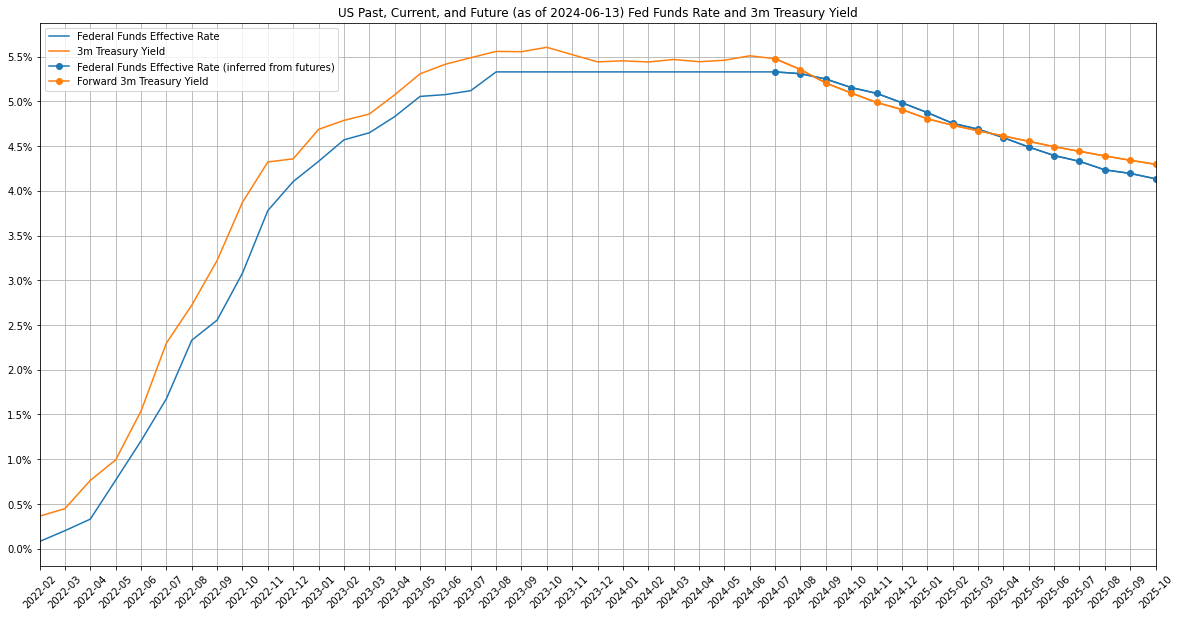

In [34]:
ax = ext_ff_tr3m.plot(figsize=(20,10), grid=True,
                      title=f'US Past, Current, and Future (as of {cur_date_curve:%Y-%m-%d}) Fed Funds Rate and 3m Treasury Yield',
                      xticks=ext_ff_tr3m.index, xlabel='', rot=45)
ext2_ff_tr3m.iloc[:,:2].plot(ax=ax, grid=True, marker='o', xticks=ext_ff_tr3m.index, xlabel='',
              rot=45, yticks=np.arange(0, .06, 0.005), color=['#1f77b4','#ff7f0e'])
# ext2_ff_tr3m.iloc[:,2:].plot(ax=ax, grid=True, marker='.', linestyle='--', xticks=ext_ff_tr3m.index, xlabel='',
#               rot=45, yticks=np.arange(0, .06, 0.005), color=['#1f77b4','#ff7f0e'])
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ext_ff_tr3m.index)))

Let's see in which month the divergence between future Fed Funds and 3 month trasury yield is the highest.

In [35]:
idx = (future_ff_tr3m_rates.iloc[:, 0] - future_ff_tr3m_rates.iloc[:, 1]).abs().idxmax()
print('Markets are expecting 3m treasury yield to be {:.2f}bps higher than Fed Funds rate in {:%Y-%m}'.
      format((ext_ff_tr3m.loc[idx, ext_ff_tr3m.columns[1]] - ext_ff_tr3m.loc[idx, ext_ff_tr3m.columns[0]])*10000,
             idx.date()))

Markets are expecting 3m treasury yield to be 16.17bps higher than Fed Funds rate in 2025-10
